In [3]:
import shutil
# Import all necessary libraries
# try:
#     %tensorflow_version 2.x
# except Exception:
#     pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model, load_model
from keras.utils import plot_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate

from sklearn.cluster import KMeans
import tensorflow_text as text

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer

import bert
from bert import bert_tokenization

import numpy as np 
import pandas as pd
import re
import glob
import os
import cv2
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as imxl
from openpyxl.utils import get_column_letter
# from natsort import natsorted
import html
from PIL import Image
import pickle
import tqdm

# from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import skimage
import string
import emoji

# Dataset Preparation

In [11]:
very_raw_elsagate_data = pd.read_csv('df_elsagate_1.csv')
very_raw_not_elsagate_data = pd.read_csv('df_not_elsagate_1.csv')
very_raw_elsagate_data.head(10)
# very_raw_not_elsagate_data.head()
# print(very_raw_elsagate_data.shape)
# print(very_raw_not_elsagate_data.shape)

,x1,x2
0,PEPPA PIG SMOKES WEED EVERYDAY,elsagate_2/elsagate_1.png
1,MLG PEPPA PIG [PARODY],elsagate_2/elsagate_2.png
2,Aussie Peppa Pig - Marijuana,elsagate_2/elsagate_3.png
3,MLG PEPPA PIG: GEORGE&#39;S WEED DAY!,elsagate_2/elsagate_4.png
4,MLG peppa pig paints weed!,elsagate_2/elsagate_5.png
5,mlg pepa pig smoke weed every day[,elsagate_2/elsagate_6.png
6,The Weed Wagon (Scottish Peppa Pig Part 5),elsagate_2/elsagate_7.png
7,MLG Peppa Pig- Weed Day,elsagate_2/elsagate_8.png
8,What happend when gorge pig got kidnapped by m...,elsagate_2/elsagate_9.png
9,Peppa pig smokes weed,elsagate_2/elsagate_10.png


In [13]:
print('duplicate elsagate data: ', very_raw_elsagate_data['x1'].duplicated().sum())
print('duplicate not elsagate data: ', very_raw_not_elsagate_data['x1'].duplicated().sum())

duplicate elsagate data:  43
duplicate not elsagate data:  152


In [14]:
# drop duplicate
alittle_bit_raw_elsagate_data = very_raw_elsagate_data.drop_duplicates(keep='first', subset='x1')
alittle_bit_raw_not_elsagate_data = very_raw_not_elsagate_data.drop_duplicates(keep='first', subset='x1')

print('number of elsagate data after eliminate duplicate:', alittle_bit_raw_elsagate_data.shape)
print('number of not elsagate data after eliminate duplicate:', alittle_bit_raw_not_elsagate_data.shape)

number of elsagate data after eliminate duplicate: (507, 2)
number of not elsagate data after eliminate duplicate: (398, 2)


In [15]:
alittle_bit_raw_elsagate_data['x1'] = alittle_bit_raw_elsagate_data['x1'].apply(html.unescape)
alittle_bit_raw_not_elsagate_data['x1'] = alittle_bit_raw_not_elsagate_data['x1'].apply(html.unescape)

alittle_bit_raw_elsagate_data['x1'][0:5]

C:\Users\farras\AppData\Local\Temp\ipykernel_20020\1568371679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alittle_bit_raw_elsagate_data['x1'] = alittle_bit_raw_elsagate_data['x1'].apply(html.unescape)
C:\Users\farras\AppData\Local\Temp\ipykernel_20020\1568371679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alittle_bit_raw_not_elsagate_data['x1'] = alittle_bit_raw_not_elsagate_data['x1'].apply(html.unescape)


0       PEPPA PIG SMOKES WEED EVERYDAY
1               MLG PEPPA PIG [PARODY]
2         Aussie Peppa Pig - Marijuana
3    MLG PEPPA PIG: GEORGE'S WEED DAY!
4           MLG peppa pig paints weed!
Name: x1, dtype: object

In [5]:
img = cv2.imread('elsagate_2/elsagate_83.png')
img = img[50:310, 5:475]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
cv2.imshow('tes', gray) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 

## Handle Shorts

### Detect Shorts

4.3139

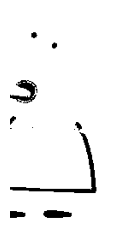

In [60]:
def visualize(image):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(image, cmap='grey')

shorts_path = "C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\Ngoding Model\\elsagate_shorts\\elsagate_43.png"
no_shorts_path = "C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\Ngoding Model\\elsagate_2\\elsagate_15.png"
ii = cv2.imread(no_shorts_path)
# ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
ii = ii[45:315, 341:480]
ret, thresh1 = cv2.threshold(ii, 120, 255, cv2.THRESH_BINARY)
black_percentage = round(100.*(1.-cv2.mean(thresh1)[0]/255.), 4)

visualize(thresh1)
black_percentage

In [61]:
# search for elsagate shorts
elsagate_detected_as_shorts = []

for i in alittle_bit_raw_elsagate_data['x2']:
    img = cv2.imread(i)
    img = img[45:315, 341:480]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    black_percentage = round(100.*(1.-cv2.mean(thresh1)[0]/255.), 4)
    if black_percentage == 100:
        elsagate_detected_as_shorts.append(i)


In [62]:
# search for not elsagate shorts
not_elsagate_detected_as_shorts = []

for i in alittle_bit_raw_not_elsagate_data['x2']:
    img2 = cv2.imread(i)
    img2 = img2[45:315, 341:480]
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    black_percentage = round(100.*(1.-cv2.mean(thresh1)[0]/255.), 4)
    if black_percentage == 100:
        not_elsagate_detected_as_shorts.append(i)

In [63]:
# check for shorts in folder
for i in elsagate_detected_as_shorts:
    shutil.copy(i, 'elsagate_shorts')
    
for i in not_elsagate_detected_as_shorts:
    shutil.copy(i, 'not_elsagate_shorts')

In [64]:
print(len(elsagate_detected_as_shorts))
print(len(not_elsagate_detected_as_shorts))

47
24


In [66]:
# after checking, delete real thumbnail in shorts list
real_vid1 = ['elsagate_2/elsagate_190.png', 'elsagate_2/elsagate_350.png', 'elsagate_2/elsagate_500.png']
real_vid2 = ['not_elsagate_2/not_elsagate_39.png', 'not_elsagate_2/not_elsagate_108.png']

filtered_elsagate_shorts = [i for i in elsagate_detected_as_shorts if i not in real_vid1]
filtered_not_elsagate_shorts = [i for i in not_elsagate_detected_as_shorts if i not in real_vid2]

print(len(filtered_elsagate_shorts))
print(len(filtered_not_elsagate_shorts))

44
22


In [119]:
# checking shorts manual method
elsagate_shorts = [18, 22, 65, 70, 77, 79, 86, 99, 111, 168, 180, 204, 223, 228, 243, 264, 290, 306, 310, 311, 
                312, 314, 317, 318, 319, 322, 331, 336, 337, 338, 341, 342, 343, 344, 345, 346, 348, 350, 380, 
                384, 391, 467, 468, 470, 472, 473, 485, 492, 501, 503, 505, 506, 507, 509, 511, 512, 514, 518, 527]

not_elsagate_shorts = [7, 9, 53, 54, 56, 57, 58, 60, 62, 65, 70, 74, 75, 81, 82, 83, 87, 88, 92, 98, 100, 145,
                        150, 195, 251, 288, 292, 300, 301, 341, 349, 362, 378, 389, 400, 401, 451, 452]

for i in range(len(elsagate_shorts)):
        real_shorts = str(f'elsagate/elsagate_{elsagate_shorts[i]}.png')
        elsagate_shorts[i] = real_shorts
        
for i in range(len(not_elsagate_shorts)):
        real_shorts2 = str(f'not_elsagate/not_elsagate_{not_elsagate_shorts[i]}.png')
        not_elsagate_shorts[i] = real_shorts2

59

### Delete Shorts

In [67]:
# delete shorts video from dataframe (elsagate)
condition1 = alittle_bit_raw_elsagate_data['x2'].isin(filtered_elsagate_shorts)
raw_elsagate_data = alittle_bit_raw_elsagate_data[~condition1]

raw_elsagate_data.shape

(463, 2)

In [68]:
# delete shorts video from dataframe (not elsagate)
condition2 = alittle_bit_raw_not_elsagate_data['x2'].isin(filtered_not_elsagate_shorts)
raw_not_elsagate_data = alittle_bit_raw_not_elsagate_data[~condition2]

raw_not_elsagate_data.shape

(376, 2)

### Delete Phase 1 and Phase 2 Data

In [31]:
# make sure phase 3 data is not contain phase 1 and phase 2 data
p1 = pd.read_excel('Phase_1.xlsx', sheet_name = 'Audy')
p2 = pd.read_excel('Phase_2.xlsx', sheet_name = 'Audy')

# merge phase 1 and phase 2 data
t1 = list(p1['Title'])
t2 = list(p2['Title'])
t3 = t1 + t2

# (A-B)
set_difference_elsagate = list(set(list(raw_elsagate_data['x1'])) - set(t3))
set_difference_not_elsagate = list(set(list(raw_not_elsagate_data['x1'])) - set(t3))

# filter intersection
condition3 = raw_elsagate_data['x1'].isin(set_difference_elsagate)
condition4 = raw_not_elsagate_data['x1'].isin(set_difference_not_elsagate)

elsagate_data = raw_elsagate_data[condition3]
not_elsagate_data = raw_not_elsagate_data[condition4]

print('number of elsagate data after eliminating intersection:', len(elsagate_data))
print('number of not elsagate data after eliminating intersection:', len(not_elsagate_data))


number of elsagate data after eliminating intersection: 438
number of not elsagate data after eliminating intersection: 342


## Labelling Preparation

### Split Data into 2 Part

In [37]:
#ELSAGATE
# randomly taking 250 data from dataframe
phase3_elsagate_data = elsagate_data.sample(n=260, random_state=10)
print(phase3_elsagate_data.shape)

# get the rest of it
rest_of_elsagate_data = elsagate_data.drop(phase3_elsagate_data.index)
print(rest_of_elsagate_data.shape)

(260, 2)
(178, 2)


In [38]:
#NOT ELSAGATE
# randomly taking 250 data from dataframe
phase3_not_elsagate_data = not_elsagate_data.sample(n=260, random_state=10)
print(phase3_not_elsagate_data.shape)

# get the rest of it
rest_of_not_elsagate_data = not_elsagate_data.drop(phase3_not_elsagate_data.index)
print(rest_of_not_elsagate_data.shape)

(260, 2)
(82, 2)


## Make Phase 1 Data

In [9]:
phase1_elsagate_data = rest_of_elsagate_data.sample(n=25, random_state=10)
phase1_not_elsagate_data = rest_of_not_elsagate_data.sample(n=25, random_state=10)

phase1_data = pd.concat([phase1_elsagate_data, phase1_not_elsagate_data], axis=0)
phase1_data = phase1_data.sample(frac=1).reset_index(drop=True)
phase1_data.tail()

,x1,x2
45,Nastya and Merry Christmas Stories for Kids,not_elsagate/not_elsagate_499.png
46,CAILLOU THE GROWNUP GETS LAID,elsagate/elsagate_435.png
47,Gone To Pieces | A Mickey Mouse Cartoon | Disn...,not_elsagate/not_elsagate_360.png
48,Cap and Spidey Unwrap the Truth! | Marvel Supe...,not_elsagate/not_elsagate_538.png
49,Peppa Pig Full Episodes 🔴 LIVE! Full Episodes ...,not_elsagate/not_elsagate_273.png


### Move Data to "phase_1" Folder

In [10]:
for i in phase1_data['x2']:
    shutil.copy(i, 'Phase_1')

print('data is ready!')

data is ready!


### Add Data to Phase_1.xlsx

In [11]:
workbook = load_workbook('Phase_1.xlsx')
worksheet = workbook['Audy']

# resize cells
for row in range(2,52):
    for col in range(2,5):
        worksheet.row_dimensions[row].height = 80
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 20

# insert images
for index, image in enumerate(list(phase1_data['x2']), 1):
    worksheet.add_image(imxl(image), anchor='B'+str(index+1))
    print(index,image)

# insert titles
for index, title in enumerate(phase1_data['x1'], 1):
    worksheet.cell(row=index+1, column=3, value=title)

# save workbook
workbook.save('Phase_1.xlsx')

1 not_elsagate/not_elsagate_313.png
2 not_elsagate/not_elsagate_156.png
3 not_elsagate/not_elsagate_19.png
4 elsagate/elsagate_138.png
5 elsagate/elsagate_276.png
6 not_elsagate/not_elsagate_157.png
7 elsagate/elsagate_76.png
8 elsagate/elsagate_515.png
9 elsagate/elsagate_103.png
10 elsagate/elsagate_271.png
11 not_elsagate/not_elsagate_459.png
12 elsagate/elsagate_364.png
13 not_elsagate/not_elsagate_407.png
14 elsagate/elsagate_265.png
15 elsagate/elsagate_190.png
16 not_elsagate/not_elsagate_483.png
17 not_elsagate/not_elsagate_505.png
18 not_elsagate/not_elsagate_469.png
19 elsagate/elsagate_445.png
20 elsagate/elsagate_263.png
21 not_elsagate/not_elsagate_290.png
22 not_elsagate/not_elsagate_370.png
23 not_elsagate/not_elsagate_504.png
24 elsagate/elsagate_395.png
25 elsagate/elsagate_411.png
26 elsagate/elsagate_471.png
27 not_elsagate/not_elsagate_172.png
28 not_elsagate/not_elsagate_93.png
29 not_elsagate/not_elsagate_441.png
30 not_elsagate/not_elsagate_162.png
31 elsagate/el

## Make Phase 2 Data

In [37]:
phase2_elsagate_data = rest_of_elsagate_data[~rest_of_elsagate_data['x2'].isin(phase1_data['x2'])].sample(n=25, random_state=1)
phase2_not_elsagate_data = rest_of_not_elsagate_data[~rest_of_not_elsagate_data['x2'].isin(phase1_data['x2'])].sample(n=26, random_state=1)

phase2_data = pd.concat([phase2_elsagate_data, phase2_not_elsagate_data], axis=0)
phase2_data = phase2_data.sample(frac=1, random_state=25).reset_index(drop=True)
phase2_data.shape

(51, 2)

### Move Data to "phase_2" Folder

In [38]:
for i in phase2_data['x2']:
    shutil.copy(i, 'Phase_2')

print('data is ready!')

data is ready!


### Add Data to Phase_2.xlsx

In [39]:
workbook = load_workbook('Phase_2.xlsx')
worksheet = workbook['Audy']

# resize cells
for row in range(2,53):
    for col in range(2,5):
        worksheet.row_dimensions[row].height = 80
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 20

# insert images
for index, image in enumerate(list(phase2_data['x2']), 1):
    worksheet.add_image(imxl(image), anchor='B'+str(index+1))
    print(index,image)

# insert titles
for index, title in enumerate(phase2_data['x1'], 1):
    worksheet.cell(row=index+1, column=3, value=title)

# save workbook
workbook.save('Phase_2.xlsx')

1 not_elsagate/not_elsagate_422.png
2 not_elsagate/not_elsagate_111.png
3 elsagate/elsagate_500.png
4 not_elsagate/not_elsagate_174.png
5 elsagate/elsagate_262.png
6 elsagate/elsagate_230.png
7 not_elsagate/not_elsagate_539.png
8 not_elsagate/not_elsagate_512.png
9 not_elsagate/not_elsagate_454.png
10 not_elsagate/not_elsagate_514.png
11 not_elsagate/not_elsagate_544.png
12 not_elsagate/not_elsagate_49.png
13 elsagate/elsagate_80.png
14 not_elsagate/not_elsagate_225.png
15 elsagate/elsagate_462.png
16 elsagate/elsagate_288.png
17 not_elsagate/not_elsagate_298.png
18 elsagate/elsagate_410.png
19 not_elsagate/not_elsagate_496.png
20 elsagate/elsagate_145.png
21 elsagate/elsagate_192.png
22 not_elsagate/not_elsagate_281.png
23 not_elsagate/not_elsagate_336.png
24 elsagate/elsagate_91.png
25 elsagate/elsagate_102.png
26 elsagate/elsagate_441.png
27 elsagate/elsagate_544.png
28 not_elsagate/not_elsagate_11.png
29 elsagate/elsagate_9.png
30 not_elsagate/not_elsagate_245.png
31 elsagate/elsag

## Make Phase 3 Data

In [40]:
# make 500+ data
# merge elsgate and not elsagate data
phase3_data = pd.concat([phase3_elsagate_data, phase3_not_elsagate_data], axis=0)
phase3_data = phase3_data.sample(frac=1, random_state=10).reset_index(drop=True) # randomize data
phase3_data.tail()
phase3_data.shape

(520, 2)

### Move Data to "phase_3" Folder

In [41]:
for i in phase3_data['x2']:
    shutil.copy(i, 'Phase_3')

print('data is ready!')

data is ready!


### Add Data to Phase_3.xlsx

In [57]:
workbook = load_workbook('Phase_3.xlsx')
worksheet = workbook['Audy']

cell_width = 50
cell_height = 155

# resize cells
for row in range(2,522):
    for col in range(2,6):
        worksheet.row_dimensions[row].height = cell_height
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = cell_width

# insert images
for index, image in enumerate(list(phase3_data['x2']), 1):
    ximg = imxl(image)
    ximg.height = 200
    ximg.width = 300
    worksheet.add_image(ximg, anchor='B'+str(index+1))
    # print(index, image)

# insert titles
for index, title in enumerate(phase3_data['x1'], 1):
    worksheet.cell(row=index+1, column=3, value=title)
    
# insert image path
for index, path in enumerate(phase3_data['x2'], 1):
    worksheet.cell(row=index+1, column=4, value=path)

# save workbook
workbook.save('Phase_3.xlsx')

# After Labelling

In [69]:
df_after_labelling_datasheet = pd.read_excel("Phase 3_done.xlsx", sheet_name='Audyy')[['Title', 'Path']].dropna()
# print(df_after_labelling_datasheet.shape)

df_after_labelling_adminsheet = pd.read_excel("Phase 3_done.xlsx", sheet_name='Admin')['Kesimpulan'].dropna().astype(int)
df_after_labelling_adminsheet.drop(df_after_labelling_adminsheet.tail(1).index, inplace=True)
# print(df_after_labelling_adminsheet.shape)

df_after_labelling = pd.concat([df_after_labelling_datasheet, df_after_labelling_adminsheet], axis=1)
df_after_labelling.head()


,Title,Path,Kesimpulan
0,Baby Anna and Elsa Learn About the Enchanted F...,not_elsagate_2/not_elsagate_134.png,0
1,Peppa and George wash the car (clip) | Peppa P...,not_elsagate_2/not_elsagate_261.png,0
2,Toy Vehicles Collection for Kids,not_elsagate_2/not_elsagate_25.png,0
3,Teen Titans Go! | Tragic Endings For The Titan...,not_elsagate_2/not_elsagate_448.png,0
4,"Help Wednesday Addams, Frozen Elsa, Ronaldo CR...",elsagate_2/elsagate_192.png,1


In [70]:
df_after_labelling.Kesimpulan.value_counts()

Kesimpulan
0    286
1    234
Name: count, dtype: int64

In [71]:
df_after_labelling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       520 non-null    object
 1   Path        520 non-null    object
 2   Kesimpulan  520 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 14.2+ KB


In [72]:
# separate 2 classes for EDA purpose
df_dark = df_after_labelling.loc[df_after_labelling['Kesimpulan'] == 1]
df_bright = df_after_labelling.loc[df_after_labelling['Kesimpulan'] == 0]

In [132]:
dark_peppapig_list = []
bright_peppapig_list = []

for i in df_dark['Title']:
    if 'peppa pig' in i.lower():
        dark_peppapig_list.append(i)
        
for i in df_bright['Title']:
    if 'peppa pig' in i.lower():
        bright_peppapig_list.append(i)
        
len(dark_peppapig_list)
len(bright_peppapig_list)

# dark_peppapig_image = df_dark[df_dark['Title'].isin(dark_peppapig_list)]
# len(dark_peppapig_image)

27

In [133]:
dark_pp_image = df_dark[df_dark['Title'].isin(dark_peppapig_list)]
bright_pp_image = df_bright[df_bright['Title'].isin(bright_peppapig_list)]

In [83]:
dark_elsa_list = []
bright_elsa_list = []

for i in df_dark['Title']:
    if re.search(r'(elsa)|(frozen)', i.lower()):
        dark_elsa_list.append(i)
        
for i in df_bright['Title']:
    if re.search(r'(elsa)|(frozen)', i.lower()):
        bright_elsa_list.append(i)
        

dark_elsa_image = df_dark[df_dark['Title'].isin(dark_elsa_list)]
bright_elsa_image = df_bright[df_bright['Title'].isin(bright_elsa_list)]
bright_elsa_image.head(10)

,Title,Path,Kesimpulan
0,Baby Anna and Elsa Learn About the Enchanted F...,not_elsagate_2/not_elsagate_134.png,0
12,Becoming Queens of Arendelle | Frozen,not_elsagate_2/not_elsagate_137.png,0
17,Frozen 5-Minute Stories: The Ghost of Arendell...,not_elsagate_2/not_elsagate_147.png,0
19,Elsa Tries to Cross the Dark Sea | Frozen,not_elsagate_2/not_elsagate_132.png,0
43,True Sisterly Love with Elsa and Anna | Frozen,not_elsagate_2/not_elsagate_129.png,0
62,Anna and Elsa's Sisterly Love | Frozen,not_elsagate_2/not_elsagate_120.png,0
72,Anna & Elsa's Winter Wonderland | Build a Snow...,not_elsagate_2/not_elsagate_104.png,0
74,Elsa Meets Bruni! | Frozen,not_elsagate_2/not_elsagate_148.png,0
89,Anna Meets Kristoff's Family | Frozen,not_elsagate_2/not_elsagate_138.png,0
114,Elsa Saves Anna | Frozen Recreated | Frozen,not_elsagate_2/not_elsagate_110.png,0


In [12]:
def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

In [82]:
# elsagate peppa pig
dark_peppapig_list = os.listdir('elsagate_2')

dark_peppapig_list.sort(key=num_sort)

dark_peppapig_list = dark_peppapig_list[0:100]

# EDA

## Check the Pattern of Title

### Hashtag

In [13]:
# use of hashtag in elsagate
hashtag_in_elsagate = []

for sentence in df_dark['Title']:
    if re.search(r'(#[A-Za-z0-9_]+)', sentence):
        hashtag_in_elsagate.append(sentence)

print('Number of elsagate title that use hashtag:' ,len(hashtag_in_elsagate))

Number of elsagate title that use hashtag: 6


In [14]:
# use of hashtag in not elsagate
hashtag_in_not_elsagate = []

for sentence in df_bright['Title']:
    if re.search(r'(#[A-Za-z0-9_]+)', sentence):
        hashtag_in_not_elsagate.append(sentence)

print('Number of NOT elsagate title that use hashtag:' , len(hashtag_in_not_elsagate))

Number of NOT elsagate title that use hashtag: 4


### Emoji

In [172]:
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+")

emoji_in_elsagate = []
emoji_in_not_elsagate = []

for sentence in df_dark['Title']:
    if re.search(EMOJI_PATTERN, sentence):
        emoji_in_elsagate.append(sentence)
        
for sentence in df_bright['Title']:
    if re.search(EMOJI_PATTERN, sentence):
        emoji_in_not_elsagate.append(sentence)
        
print('Number of elsagate title that use emoji:' , len(emoji_in_elsagate))
print('Number of NOT elsagate title that use emoji:' , len(emoji_in_not_elsagate))

Number of elsagate title that use emoji: 13
Number of NOT elsagate title that use emoji: 31


In [16]:
string_of_elsagate_titles = ' '.join(df_dark['Title'])
emo1 = emoji.emoji_count(string_of_elsagate_titles)
print('Number emoji used in elsagate title:' , emo1)

string_of_not_elsagate_titles = ' '.join(df_bright['Title'])
emo2 = emoji.emoji_count(string_of_not_elsagate_titles)
print('Number emoji used in NOT elsagate title:' , emo2)

Number emoji used in elsagate title: 17
Number emoji used in NOT elsagate title: 44


### Symbol and Punctuation

In [17]:
punct_elsagate = []
punct_not_elsagate = []

for sentence in df_dark['Title']:
    if re.search(r'[^\w\s]', sentence):
        punct_elsagate.append(sentence)
        
for sentence in df_bright['Title']:
    if re.search(r'[^\w\s]', sentence):
        punct_not_elsagate.append(sentence)

print('Number of elsagate title that use punctuation:' , len(punct_elsagate))
print('Number of NOT elsagate title that use punctuation:', len(punct_not_elsagate))

Number of elsagate title that use punctuation: 154
Number of NOT elsagate title that use punctuation: 241


In [18]:
punct1 = re.findall(r'[^\w\s]', string_of_elsagate_titles)
print('Number of punctuation in elsagate title:' , len(punct1))

punct2 = re.findall(r'[^\w\s]', string_of_not_elsagate_titles)
print('Number of punctuation in NOT elsagate title:' , len(punct2))

Number of punctuation in elsagate title: 379
Number of punctuation in NOT elsagate title: 767


## Conclusion
Dari pengecekan hashtag, emoji, simbol, dan tanda baca, dapat disimulkan bahwa: 
- Tidak ada perbedaan signifikan pada penggunaan hashtag
- Terdapat perbedaan yang cukup banyak pada penggunaan emoji, yaitu 17:44
- Terdapat perbedaan yang cukup banyak pada penggunaan tanda baca dan simbol, yaitu 379:767

Sehingga, agar polanya semakin terlihat, lebih baik simbol dan tanda baca tetap ada. Emoji tetap dibersihkan karena terlalu random

## Wordcloud

- wordcloud judul elsagate dan bukan 
- wordcloud frozen elsa dan bukan 

In [170]:
def text_processing(sentences):
    kalimat = sentences
    kalimat_lower = kalimat.lower()
    kalimat_nonum = re.sub(r"\d+", "", kalimat_lower)
    kalimat_nomention = re.sub(r'(@[A-Za-z0-9_]+)', '', kalimat_nonum)
    kalimat_nohashtag = re.sub(r'(#[A-Za-z0-9_]+)','', kalimat_nomention)
    kalimat_nolink = re.sub('http://\S+|https://\S+', '', kalimat_nohashtag)
    kalimat_nopunct = kalimat_nolink.translate(str.maketrans("","",string.punctuation))
    kalimat_nopunct2 = re.sub(r'[^\w\s]','', kalimat_nopunct)
    kalimat_nospace = kalimat_nopunct2.strip()
    kalimat_noemot = re.sub(EMOJI_PATTERN, '', kalimat_nospace)
    
    return kalimat_noemot

def text_processing2(sentences):
    kalimat = sentences
    kalimat_lower = kalimat.lower()
    kalimat_nonum = re.sub(r"\d+", "", kalimat_lower)
    kalimat_nohashtag = re.sub(r'(#[A-Za-z0-9_]+)','', kalimat_nonum)
    kalimat_nolink = re.sub('http://\S+|https://\S+', '', kalimat_nohashtag)
    kalimat_noemot = re.sub(EMOJI_PATTERN, '', kalimat_nolink)
    
    return kalimat_noemot

def words(iterable):
    comment_words = ''
    
    # iterate through the csv file
    for v in iterable:
        # split the value
        tokens = str(v).split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
        comment_words += " ".join(tokens)+" "
    
    return comment_words

stopwords = set(STOPWORDS)
font_path = "C:\SAINS DATA\Font\monsterat\static\Montserrat-SemiBold.ttf"

def wc(words, list_of_stopwords=None):
    wordcloud = WordCloud(width = 900, height = 600,
                    background_color ="rgba(255, 255, 255, 0)", mode="RGBA",
                    stopwords = list(stopwords) + list_of_stopwords,
                    min_font_size = 20,
                    max_font_size= 150,
                    colormap='magma',
                    font_path = font_path).generate(words)

    # plt.figure(figsize = (6, 4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

NameError: name 'STOPWORDS' is not defined

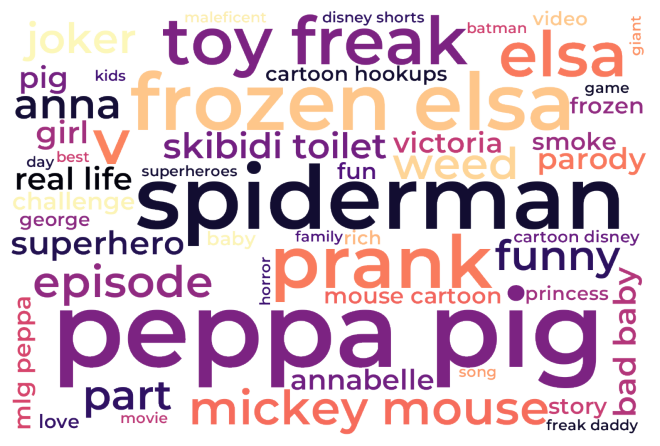

In [75]:
# elsagate all with text processing
df_dark_clean = df_dark['Title'].apply(text_processing)
wc(words(df_dark_clean), [])

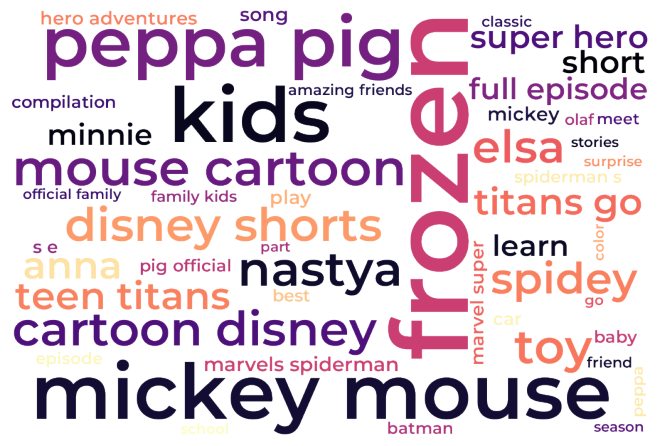

In [76]:
# not elsagate all with text processing 
df_bright_clean = df_bright['Title'].apply(text_processing)
wc(words(df_bright_clean), [])

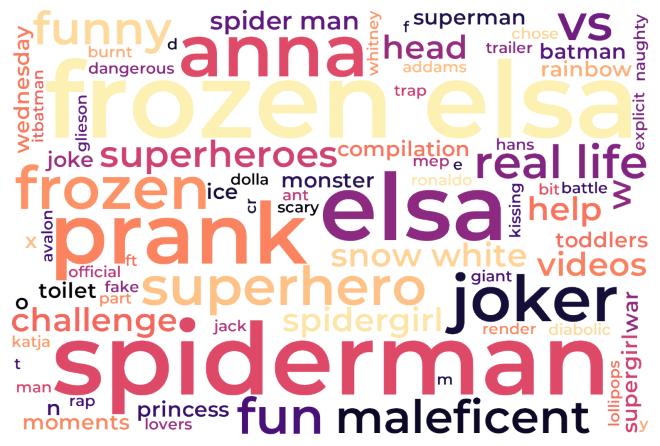

In [79]:
# elsa all with text processing
dark_elsa_list_clean = map(text_processing , dark_elsa_list)
wc(words(dark_elsa_list_clean), [])

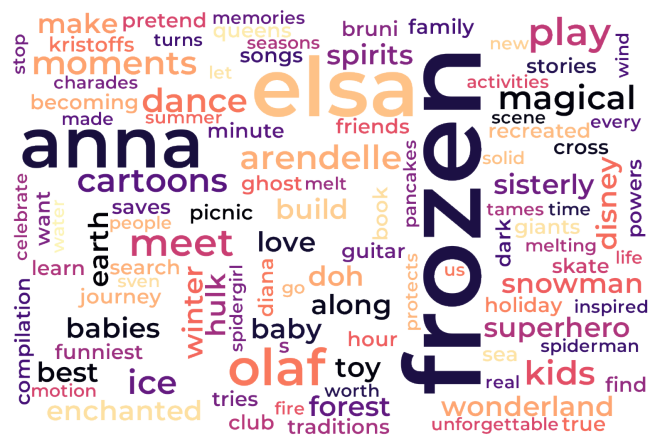

In [84]:
# elsa all with text processing
bright_elsa_list_clean = map(text_processing , bright_elsa_list)
wc(words(bright_elsa_list_clean), [])

## Dominant Colors

In [73]:
IMAGE_SIZE = (480, 360)  
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def load_images_from_df(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img[50:310, 5:475]
        if img is not None:
            images.append(img)
    return np.array(images, dtype='uint8')

def load_images_from_df_but_HSV(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img[50:310, 5:475]
        if img is not None:
            images.append(img)
    return np.array(images, dtype='uint8')

def load_images_from_df_but_LUV(df):
    images = []
    for filename in df:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img[50:310, 5:475]
        if img is not None:
            images.append(img)
    return np.array(images, dtype='uint8')

In [74]:
elsagate_image = load_images_from_df(df_dark['Path'])
not_elsagate_image = load_images_from_df(df_bright['Path'])
# print(elsagate_image.shape)

elsagate_image_2d = elsagate_image.reshape(-1, elsagate_image.shape[1]*elsagate_image.shape[2]*elsagate_image.shape[3])
not_elsagate_image_2d = not_elsagate_image.reshape(-1, not_elsagate_image.shape[1]*not_elsagate_image.shape[2]*not_elsagate_image.shape[3])
print(elsagate_image_2d.shape)
print(not_elsagate_image_2d.shape)

(234, 366600)
(286, 366600)


In [88]:
frozen_jahat = load_images_from_df(dark_elsa_image['Path'])
frozen_baik = load_images_from_df(bright_elsa_image['Path'])

frozen_jahat_2d = frozen_jahat.reshape(-1, frozen_jahat.shape[1]*frozen_jahat.shape[2]*frozen_jahat.shape[3])
frozen_baik_2d = frozen_baik.reshape(-1, frozen_baik.shape[1]*frozen_baik.shape[2]*frozen_baik.shape[3])

frozen_jahat_2d.shape
# frozen_baik_2d.shape

(42, 366600)

In [135]:
pp_jahat = load_images_from_df(dark_pp_image['Path'])
pp_baik = load_images_from_df(bright_pp_image['Path'])

pp_jahat_2d = pp_jahat.reshape(-1, pp_jahat.shape[1]*pp_jahat.shape[2]*pp_jahat.shape[3])
pp_baik_2d = pp_baik.reshape(-1, pp_baik.shape[1]*pp_baik.shape[2]*pp_baik.shape[3])

pp_jahat_2d.shape
pp_baik_2d.shape

(27, 366600)

In [101]:
import os
from colorthief import ColorThief

dominant_colors = {}

for image in df_dark['Path']:
    color_thief = ColorThief(image)

    dominant_colors.update({(image, color_thief.get_color(quality=1))})

for image, dominant_color in dominant_colors.items():
    print(image, dominant_color)

elsagate_2/elsagate_192.png (14, 13, 14)
not_elsagate_2/not_elsagate_358.png (191, 236, 235)
elsagate_2/elsagate_215.png (6, 8, 10)
elsagate_2/elsagate_514.png (34, 37, 17)
elsagate_2/elsagate_64.png (150, 195, 213)
elsagate_2/elsagate_89.png (172, 111, 171)
elsagate_2/elsagate_157.png (19, 13, 10)
elsagate_2/elsagate_257.png (38, 31, 26)
elsagate_2/elsagate_241.png (192, 106, 140)
elsagate_2/elsagate_136.png (197, 179, 171)
elsagate_2/elsagate_459.png (188, 178, 159)
elsagate_2/elsagate_217.png (46, 36, 36)
not_elsagate_2/not_elsagate_29.png (205, 204, 196)
not_elsagate_2/not_elsagate_379.png (10, 30, 28)
elsagate_2/elsagate_95.png (149, 180, 221)
elsagate_2/elsagate_200.png (174, 164, 158)
elsagate_2/elsagate_484.png (31, 27, 24)
elsagate_2/elsagate_50.png (55, 54, 63)
elsagate_2/elsagate_498.png (204, 139, 141)
elsagate_2/elsagate_1.png (157, 174, 178)
elsagate_2/elsagate_41.png (216, 176, 180)
elsagate_2/elsagate_411.png (215, 221, 216)
elsagate_2/elsagate_519.png (215, 169, 137)
e

In [164]:
number_of_colors = 3
clf = KMeans(n_clusters = number_of_colors, random_state = 10)
labels1 = clf.fit_predict(elsagate_image_2d)

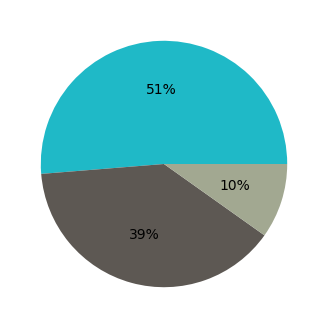

In [165]:
from collections import Counter

counts = Counter(labels1)

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

plt.figure(figsize = (6, 4))
plt.pie(counts.values(), colors = hex_colors, autopct='%.0f%%')
# plt.title('Most Used Colors in Real Frozen Thumbnail')
plt.show()

In [166]:
clf2 = KMeans(n_clusters = number_of_colors, random_state = 10)
labels2 = clf2.fit_predict(not_elsagate_image_2d)

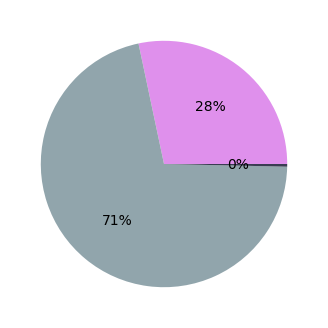

In [167]:
counts2 = Counter(labels2)

center_colors2 = clf2.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors2 = [center_colors2[i] for i in counts2.keys()]
hex_colors2 = [RGB2HEX(ordered_colors2[i]) for i in counts2.keys()]
rgb_colors = [ordered_colors[i] for i in counts2.keys()]

plt.figure(figsize = (6, 4))
plt.pie(counts2.values(), colors = hex_colors2, autopct='%.0f%%')
# plt.title('Most Used Colors in Elsagate Frozen Thumbnail')
plt.show()

In [162]:
from sklearn.model_selection import train_test_split
X = very_raw_data[['x1', 'x2']]
y = very_raw_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)

(225, 2)


In [160]:
for i in X_test['x2']:
    shutil.copy(i, 'test')

In [161]:
for i in X_train['x2']:
    shutil.copy(i, 'train')

# Try and Error

## Percobaan Pertama

In [7]:
def get_missing(file, df):
  parts = file.split(os.sep)
  idx = parts[-1]
  cls = parts[-2]
  indexes = df[:,0]
  classes = df[:,2]

  if idx in indexes:
    text = df[idx == indexes][0,1]
    return pd.NA, pd.NA, pd.NA
  else:
    text = df[cls == classes][0,1]
    
  return idx, text, cls   

vec_get_missing = np.vectorize(get_missing, signature='(),(m,n)->(),(),()')

In [9]:
# Function for images loading

def add_not_found(path, df):
  files = glob.glob(path)
  df = df.reset_index()
  idxs, texts, cls = vec_get_missing(files, df.values)
  
  found = pd.DataFrame({"text": texts,
                        "food": cls,
                       "image_path": idxs})
  na = found.isna().sum().values[0]
  if na<found.shape[0]:
    df = df.append(found)
  df = df.drop_duplicates(subset='image_path', keep='first').dropna()
  df = df.set_index('image_path')
  df = shuffle(df, random_state = 0)
  return df 

In [16]:
type(X_train)

pandas.core.frame.DataFrame

In [18]:
train = add_not_found('train/*.png', X_train)

print("Number of training images:", train.shape[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Images folders 
train = add_not_found('images/train/*/*.jpg', train)
test = add_not_found('images/test/*/*.jpg', test)

print("Number of training images:",train.shape[0])
print("Number of test images:",test.shape[0])

In [6]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [20]:
# Preprocessing of texts according to BERT +
# Cleaning of the textst

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

def get_tokens(text, tokenizer):
  tokens = tokenizer.tokenize(text)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  length = len(tokens)
  if length > max_length:
      tokens = tokens[:max_length]
  return tokens, length  

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    image_name = parts[-1]
    is_train = parts[-3] == 'train'
    if is_train:
      df = train
    else:
      df = test

    text = df['text'][image_name]
    return text
vec_get_text = np.vectorize(get_texts)
def prepare_text(paths):
    #Preparing texts
    
    texts = vec_get_text(paths)
    
    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)
    
    return ids, segments, masks

def clean(i, tokens):
  try:
    this_token = tokens[i]
    next_token = tokens[i+1]
  except:
    return tokens
  if '##' in next_token:
      tokens.remove(next_token)
      tokens[i] = this_token + next_token[2:]
      tokens = clean(i, tokens)
      return tokens
  else:
    i = i+1
    tokens = clean(i, tokens)
    return tokens

def clean_text(array):
  array = array[(array!=0) & (array != 101) & (array != 102)]
  tokens = tokenizer.convert_ids_to_tokens(array)
  tokens = clean(0, tokens)
  text = ' '.join(tokens)
  return text

## Percobaan Kedua

In [22]:
very_raw_data['x1'].apply(preprocess_text)
very_raw_data.head()

,x1,x2,x2_local,y
0,"Oh, our hearts 🥹✨🫶",https://i.ytimg.com/vi/PrDbrqYZaPA/default.jpg,not_elsagate/b8hYj0ROMo4.png,0
1,peppa pig death scene 2020 hd leaked,https://i.ytimg.com/vi/IoInybOpFZ0/default.jpg,elsagate/4zcfDrgHILs.png,1
2,Peppa pig et morte ☠️ peppa is dead 💀,https://i.ytimg.com/vi/p8QlZBCHa8k/default.jpg,elsagate/HEyqytq0-is.png,1
3,Be careful what you wish for ⭐️ Watch the NEW ...,https://i.ytimg.com/vi/j3Ji6loqyZs/default.jpg,not_elsagate/hImeU_jqqOU.png,0
4,PEEPA PIG: OGRE SLAYER,https://i.ytimg.com/vi/yT21dNMgBgQ/default.jpg,elsagate/3gKR2LdPhzs.png,1


In [47]:
max_seq_length = 256  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [48]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [49]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [50]:
def get_ids_masks_segmenets(sentence):
    stokens = tokenizer.tokenize(sentence)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    input_ids = get_ids(stokens, tokenizer, max_seq_length)
    input_masks = get_masks(stokens, max_seq_length)
    input_segments = get_segments(stokens, max_seq_length)
    return input_ids, input_masks, input_segments


def build_ids_masks_segments(sentences):
    input_ids_ = []
    input_masks_ = []
    input_segments_ = []
    for s in sentences:
        input_ids, input_masks, input_segments = get_ids_masks_segmenets(s)
        input_ids_.append(input_ids)
        input_masks_.append(input_masks)
        input_segments_.append(input_segments)
    return input_ids_, input_masks_, input_segments_

def get_embeddings(sentences):
    input_ids, input_masks, input_segments = build_ids_masks_segments(sentences)
    pool_embs, all_embs = model.predict([input_ids,input_masks,input_segments])
    return all_embs

In [55]:
print(get_embeddings(["hey", "yay"]).shape)

ValueError: in user code:

    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2, 256) dtype=int32>]


In [ ]:
X_train = get_embeddings(X_train['x1'].values)

ValueError: in user code:

    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 75, 256) dtype=int32>]


## Percobaan Ketiga

In [4]:
class_names_label = {'not_elsagate' : 0,
                    'elsagate':1 }
print(class_names_label)
# nb_classes = len(class_names)

IMAGE_SIZE = (120, 90)
class_names = ['not_elsagate', 'elsagate']

{'not_elsagate': 0, 'elsagate': 1}


In [5]:
def load_image():
    datasets = ['train', 'test']
    output = []
    
    for i in datasets:
        images = []
        labels = []
        
        for file in os.listdir(i):
            image = cv2.imread(f'{i}/{file}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            
            images.append(image)
            
            if f'elsagate/{file}' in list(very_raw_data['x2_local']):
                labels.append(1)
            else:
                labels.append(0)
        images = np.array(images, dtype = 'uint8')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_image()

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image of size: {}".format(train_images.shape))

Number of training examples: 75
Number of testing examples: 25
Each image of size: (75, 90, 120, 3)


In [8]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

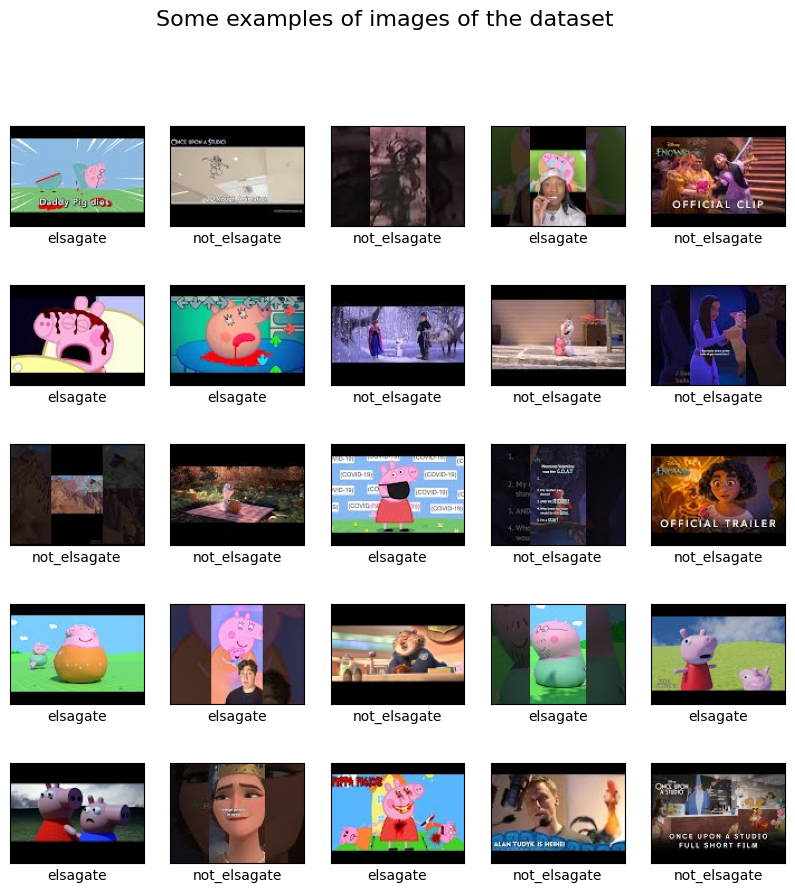

In [9]:
display_examples(class_names, train_images, train_labels)

In [10]:
visible = Input(shape=(90,120,3))
conv1 = Conv2D(256, kernel_size=4, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(10, activation='relu')(flat)
output = Dense(1, activation='sigmoid')(hidden1)

model_image = Model(inputs=visible, outputs=output)
# summarize layers
print(model_image.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 120, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 87, 117, 256)      12544     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 58, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 55, 64)        262208    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 27, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 34560)             0     

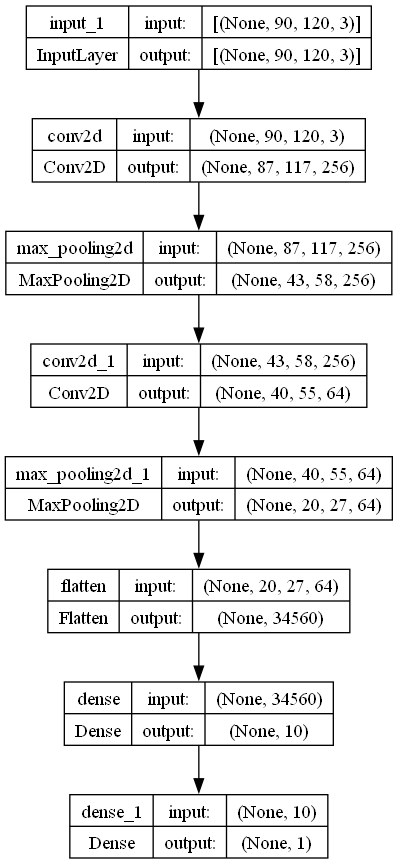

In [146]:
# plot graph
plot_model(model_image, to_file='convolutional_neural_network.png', show_shapes=True, show_layer_names=True)

In [15]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
 tf.keras.metrics.Precision(name='precision'),
 tf.keras.metrics.Recall(name='recall')]

model_image.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=Metrics)

In [16]:
training_history = model_image.fit(train_images, train_labels,
                	        epochs=30, batch_size=32,
                	        validation_data=(test_images, test_labels))

Epoch 1/30
3/3 [==============================] - 13s 969ms/step - loss: 88.4044 - accuracy: 0.4800 - precision: 0.4565 - recall: 0.6000 - val_loss: 0.6931 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 2/30
3/3 [==============================] - 0s 106ms/step - loss: 0.6931 - accuracy: 0.5067 - precision: 0.4688 - recall: 0.4286 - val_loss: 0.6911 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 0s 99ms/step - loss: 0.6931 - accuracy: 0.5333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6887 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 0s 104ms/step - loss: 0.6931 - accuracy: 0.5333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6866 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 0s 100ms/step - loss:

In [18]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

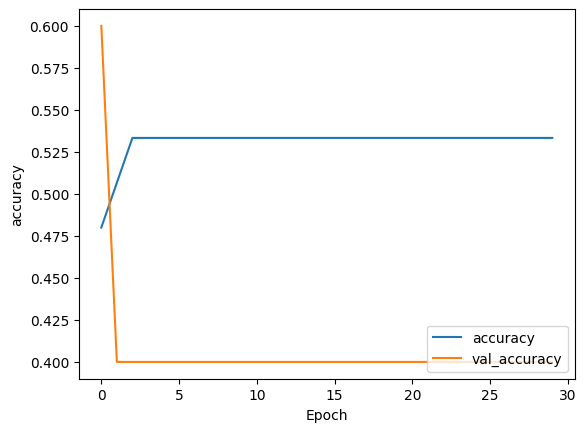

In [19]:
show_performance_curve(training_history, 'accuracy', 'accuracy')

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(very_raw_data['x1'], very_raw_data['y'], test_size=0.25, random_state=42)
X_train2

15                        Peppa Pig Horror Movie Parody
40                &quot;Swing&quot; l At Home With Olaf
96                 Winnie the Pooh: Brand New Adventure
9            3 DARK CARTOON CONSPIRACY STORIES ANIMATED
72    100 Years of Disney Animation: The Little Merm...
                            ...                        
60    Disney&#39;s Once Upon a Studio | Full Short Film
71    Wreck-It Ralph &quot;Ralph&#39;s Gone Turbo&qu...
14    100 Years of Disney Animation: Bambi Character...
92                              Peppa Pig - Coronavirus
51    All he asks for is a little respect #Wish #Wis...
Name: x1, Length: 75, dtype: object

In [111]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [72]:
test_text = ['nice picture indeed','I like java programming']
TextPreprocessed = bert_preprocess(test_text)
TextPreprocessed.keys()

dict_keys(['input_type_ids', 'input_word_ids', 'input_mask'])

In [73]:
TextPreprocessed['input_mask']

<tf.Tensor: shape=(2, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [74]:
TextPreprocessed['input_word_ids']

<tf.Tensor: shape=(2, 128), dtype=int32, numpy=
array([[ 101, 3835, 3861, 5262,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 1045, 2066, 9262, 4730,  102,    0,    0,    0,    0,    0,
           0,

In [77]:
BertResults = bert_encoder(TextPreprocessed)
BertResults.keys()

dict_keys(['encoder_outputs', 'default', 'pooled_output', 'sequence_output'])

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
l = tf.keras.layers.LSTM(64, activation='relu')(l)
l = tf.keras.layers.Dense(16, activation='relu')(l)
l = tf.keras.layers.Dropout(0.1, name="dropout")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_text[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

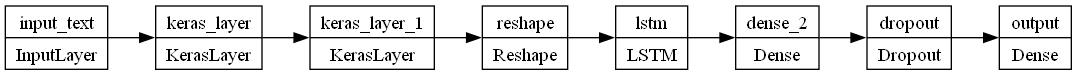

In [148]:
plot_model(model, to_file='textmodel_plot.png', rankdir='LR')

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [26]:
history = model.fit(X_train2, y_train2, epochs=50)

Epoch 1/50
3/3 [==============================] - 16s 490ms/step - loss: 0.6945 - accuracy: 0.4600 - precision: 0.4474 - recall: 0.3400
Epoch 2/50
3/3 [==============================] - 2s 458ms/step - loss: 0.6725 - accuracy: 0.7067 - precision: 0.6757 - recall: 0.7143
Epoch 3/50
3/3 [==============================] - 2s 436ms/step - loss: 0.6445 - accuracy: 0.6800 - precision: 0.6410 - recall: 0.7143
Epoch 4/50
3/3 [==============================] - 2s 441ms/step - loss: 0.6270 - accuracy: 0.6800 - precision: 0.6222 - recall: 0.8000
Epoch 5/50
3/3 [==============================] - 2s 444ms/step - loss: 0.5685 - accuracy: 0.7067 - precision: 0.7600 - recall: 0.5429
Epoch 6/50
3/3 [==============================] - 2s 441ms/step - loss: 0.5366 - accuracy: 0.7467 - precision: 0.6600 - recall: 0.9429
Epoch 7/50
3/3 [==============================] - 2s 455ms/step - loss: 0.5493 - accuracy: 0.7467 - precision: 0.8333 - recall: 0.5714
Epoch 8/50
3/3 [==============================] - 2s 4

In [27]:
model.evaluate(X_test2, y_test2)

1/1 [==============================] - 2s 2s/step - loss: 0.1589 - accuracy: 0.9200 - precision: 0.9333 - recall: 0.9333


[0.15889683365821838,
 0.9200000166893005,
 0.9333333373069763,
 0.9333333373069763]

In [111]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

KeyError: 'val_loss'

In [28]:
y_predicted = model.predict(X_test2)
y_predicted = y_predicted.flatten()
y_predicted

1/1 [==============================] - 3s 3s/step


array([0.9977089 , 0.06149622, 0.99936813, 0.9997086 , 0.16595636,
       0.9952519 , 0.689324  , 0.18017758, 0.05630426, 0.15122484,
       0.04272546, 0.9999305 , 0.27018586, 0.6403824 , 0.21007518,
       0.98824394, 0.92833954, 0.9981705 , 0.99918324, 0.9999474 ,
       0.3581694 , 0.9999169 , 0.84769803, 0.9882784 , 0.01677033],
      dtype=float32)

In [29]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0])

In [30]:
confusion_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

NameError: name 'y_test' is not defined

In [31]:
samples = ['The Tropical Day Trip 🍹 | Peppa Pig Official Full Episodes', "No Way...! Please Wake Up Peppa ? | Peppa Pig Funny Animation"]
model.predict(samples)

1/1 [==============================] - 2s 2s/step


array([[0.94787765],
       [0.9930783 ]], dtype=float32)

# Data Adjusments
Proses ini bertujuan untuk menyiapkan data sebelum masuk dalam pemodelan. Langkah yang dilakukan:
- Pembersihan data teks 
- menyiapkan dataframe agar sesuai dengan input
- lemmatization
- downsampling
- menghapus kata asing

In [199]:
df_after_labelling.Title[0:20]

0     Baby Anna and Elsa Learn About the Enchanted F...
1     Peppa and George wash the car (clip) | Peppa P...
2                      Toy Vehicles Collection for Kids
3     Teen Titans Go! | Tragic Endings For The Titan...
4     Help Wednesday Addams, Frozen Elsa, Ronaldo CR...
5     Nature’s Wonderland | A Mickey Mouse Cartoon |...
6     The Potty Song | The Rocking Potty Rock | FunP...
7     How to Make Island on the Water?  Floating Isl...
8            Teen Titans Go! | Secret Keeping | @dckids
9                                Peppa Pig Kills George
10    Spidey Nabs Nebula! | Marvel Super Hero Advent...
11        Nastya and stories about diversity among kids
12                Becoming Queens of Arendelle | Frozen
13                    Peppa Pig on YouTube Kids be like
14             FROZEN X DIABOLIC LOVERS | Hans Bit Elsa
15     Dinosaur and Poli cars round track play car toys
16                  Beep beep tv toy freaks stop motion
17    Frozen 5-Minute Stories: The Ghost of Aren

In [214]:
df_copy = df_after_labelling.copy()
df_copy.head()

,Title,Path,Kesimpulan
0,Baby Anna and Elsa Learn About the Enchanted F...,not_elsagate_2/not_elsagate_134.png,0
1,Peppa and George wash the car (clip) | Peppa P...,not_elsagate_2/not_elsagate_261.png,0
2,Toy Vehicles Collection for Kids,not_elsagate_2/not_elsagate_25.png,0
3,Teen Titans Go! | Tragic Endings For The Titan...,not_elsagate_2/not_elsagate_448.png,0
4,"Help Wednesday Addams, Frozen Elsa, Ronaldo CR...",elsagate_2/elsagate_192.png,1


In [215]:
# Pembersihan Title
df_copy['Title'] = df_copy['Title'].apply(text_processing)
df_copy.head(10)

,Title,Path,Kesimpulan
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0
1,peppa and george wash the car clip peppa pig ...,not_elsagate_2/not_elsagate_261.png,0
2,toy vehicles collection for kids,not_elsagate_2/not_elsagate_25.png,0
3,teen titans go tragic endings for the titans,not_elsagate_2/not_elsagate_448.png,0
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1
5,natures wonderland a mickey mouse cartoon di...,not_elsagate_2/not_elsagate_358.png,1
6,the potty song the rocking potty rock funpop...,elsagate_2/elsagate_215.png,1
7,how to make island on the water floating island,elsagate_2/elsagate_514.png,1
8,teen titans go secret keeping,not_elsagate_2/not_elsagate_405.png,0
9,peppa pig kills george,elsagate_2/elsagate_64.png,1


In [216]:
df_copy['Title'][518]

'minnie and daisys happiest day   mickey mouse mixedup adventures'

In [217]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df_copy['Title'] = df_copy['Title'].apply(lemmatize_words)
df_copy.head(20)


,Title,Path,Kesimpulan
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1
5,nature wonderland a mickey mouse cartoon disne...,not_elsagate_2/not_elsagate_358.png,1
6,the potty song the rocking potty rock funpop crew,elsagate_2/elsagate_215.png,1
7,how to make island on the water floating island,elsagate_2/elsagate_514.png,1
8,teen titan go secret keeping,not_elsagate_2/not_elsagate_405.png,0
9,peppa pig kill george,elsagate_2/elsagate_64.png,1


In [218]:
df_copy['Title'][518]

'minnie and daisy happiest day mickey mouse mixedup adventure'

In [220]:
image_array = load_images_from_df(df_copy['Path'])
image_array = list(image_array)

df_copy['Image Array'] = image_array
df_copy

,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[24, 4, 63], [24, 4, 63], [24, 4, 63], [24, ..."
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0,"[[[147, 192, 249], [147, 192, 249], [147, 192,..."
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0,"[[[76, 155, 247], [76, 157, 239], [76, 156, 24..."
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0,"[[[97, 244, 254], [97, 244, 254], [97, 244, 25..."
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1,"[[[248, 159, 91], [242, 159, 93], [243, 162, 9..."
...,...,...,...,...
515,peppa pig on a weed farm,elsagate_2/elsagate_29.png,1,"[[[150, 197, 251], [150, 197, 251], [150, 197,..."
516,elsa protects olaf in the enchanted forest frozen,not_elsagate_2/not_elsagate_139.png,0,"[[[78, 134, 209], [75, 131, 208], [69, 125, 20..."
517,roughin it a mickey mouse cartoon disney short,not_elsagate_2/not_elsagate_375.png,0,"[[[179, 168, 53], [182, 169, 55], [186, 173, 5..."
518,minnie and daisy happiest day mickey mouse mix...,elsagate_2/elsagate_397.png,0,"[[[207, 179, 202], [210, 182, 197], [214, 182,..."


In [86]:
df_copy['Image Array'][0].shape

(260, 470, 3)

In [96]:
def downsampling(img):
    lower_img = cv2.pyrDown(img)
    return lower_img

df_copy['Image Array'] = df_copy['Image Array'].apply(downsampling)
df_copy.head(10)

C:\Users\farras\AppData\Local\Temp\ipykernel_23936\3162826942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Image Array'] = df_copy['Image Array'].apply(downsampling)


,Title,Path,Kesimpulan,Image Array
0,baby anna and elsa learn about the enchanted f...,not_elsagate_2/not_elsagate_134.png,0,"[[[170, 247, 61], [170, 247, 61], [170, 247, 6..."
1,peppa and george wash the car clip peppa pig o...,not_elsagate_2/not_elsagate_261.png,0,"[[[13, 104, 249], [13, 104, 249], [13, 104, 24..."
2,toy vehicle collection for kid,not_elsagate_2/not_elsagate_25.png,0,"[[[14, 174, 244], [14, 175, 245], [14, 179, 24..."
3,teen titan go tragic ending for the titan,not_elsagate_2/not_elsagate_448.png,0,"[[[28, 157, 254], [28, 157, 254], [28, 158, 25..."
4,help wednesday addams frozen elsa ronaldo cr a...,elsagate_2/elsagate_192.png,1,"[[[107, 158, 244], [107, 155, 243], [107, 155,..."
5,nature wonderland a mickey mouse cartoon disne...,not_elsagate_2/not_elsagate_358.png,1,"[[[33, 165, 120], [34, 166, 121], [35, 159, 12..."
6,the potty song the rocking potty rock funpop crew,elsagate_2/elsagate_215.png,1,"[[[51, 109, 190], [21, 157, 234], [15, 182, 25..."
7,how to make island on the water floating island,elsagate_2/elsagate_514.png,1,"[[[26, 211, 232], [25, 189, 237], [24, 160, 24..."
8,teen titan go secret keeping,not_elsagate_2/not_elsagate_405.png,0,"[[[29, 73, 255], [30, 74, 254], [31, 78, 255],..."
9,peppa pig kill george,elsagate_2/elsagate_64.png,1,"[[[14, 97, 247], [14, 97, 247], [14, 97, 247],..."


In [18]:
df_copy['Image Array'][0].shape

(130, 235, 3)

In [177]:
def isEnglish(s):
    return s.isascii()

non_english_words = []

for i in df_copy["Title"]:
    if isEnglish(i) == False:
        non_english_words.append(i)

non_english_words

['chintu ke karname part चट क करनम परट mota chintu comedy chintu toon',
 'pepa pig haciendo un cover de snoop dogg versión cumbia cover song smoke weed everyday',
 'hombre araña spiderman frozen',
 'aalu ki barat kid hindi hindi cartoon video आल क बरत',
 'детская песенка потешка про ферму и макдональда от лайк настя']

In [180]:
df_copy.loc[df_copy['Title'].isin(non_english_words)]

,Title,Path,Kesimpulan
166,chintu ke karname part चट क करनम परट mota chin...,not_elsagate_2/not_elsagate_89.png,1
224,pepa pig haciendo un cover de snoop dogg versi...,elsagate_2/elsagate_14.png,1
277,hombre araña spiderman frozen,elsagate_2/elsagate_146.png,1
389,aalu ki barat kid hindi hindi cartoon video आल...,not_elsagate_2/not_elsagate_99.png,0
484,детская песенка потешка про ферму и макдональд...,not_elsagate_2/not_elsagate_467.png,0


In [20]:
condition5 = df_copy['Title'].isin(non_english_words)
df_copy = df_copy[~condition5]
df_copy.shape

(515, 4)

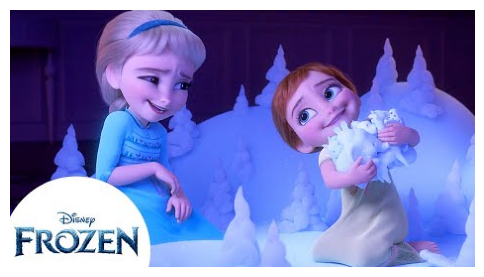

In [227]:
ori = df_copy['Image Array'][0]
def downsampling(img):
    lower_img = cv2.pyrDown(img)
    return lower_img

def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image, cmap='grey')
    
# visualize(downsampling(ori))
visualize(ori)
# cv2.imshow('ori', ori)
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 

# turun = cv2.pyrDown(ori)
# cv2.imshow('ori', turun)
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 

# Multimodal

In [163]:
aa = []
for i in very_raw_data['x2']:
    ar = cv2.imread(i)
    aa.append(ar)

very_raw_data['image_array'] = aa
very_raw_data.head()

,x1,x2,y,image_array
0,peppa pig and suzy sheep visits the tiny land,not_elsagate/0YPlAXQJPjs.png,0,"[[[0, 2, 1], [0, 2, 1], [0, 2, 1], [0, 2, 1], ..."
1,peppa pig zombie attack,elsagate/6PpPum4VVqA.png,1,"[[[4, 0, 0], [4, 0, 0], [2, 0, 0], [2, 0, 0], ..."
2,peppa pig full episodes suzy goes away carto...,elsagate/0lKvFNSGuXw.png,1,"[[[2, 0, 11], [2, 0, 8], [2, 0, 1], [2, 1, 0],..."
3,🐻 peppa pigs new toy cupboard 🐻,not_elsagate/BsK0CvZjvEo.png,0,"[[[0, 0, 3], [0, 0, 0], [4, 2, 0], [4, 2, 0], ..."
4,peppa pig becomes broccoli in hollywood peppa ...,not_elsagate/9oG6LzYqCts.png,0,"[[[0, 0, 8], [0, 0, 6], [0, 2, 0], [0, 5, 0], ..."


In [4]:
train_df, val_df, test_df = df_copy[:416], df_copy[416:468], df_copy[468:]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(416+52+47)

NameError: name 'df_copy' is not defined

In [3]:
def get_X_y(df):
  X_txt, X_img = [], []
  y = []
  
  for i in range(len(df)):
    X_txt.append(df['Title'].iloc[i])
    X_img.append(df['Image Array'].iloc[i])
    y.append(df['Kesimpulan'].iloc[i])

  X_txt, X_img = np.array(X_txt), np.array(X_img)
  y_fix = np.array(y)

  return (X_txt, X_img), y_fix


In [100]:
(X_train_txt, X_train_img), y_train = get_X_y(train_df)

# Get the training data
(X_train_txt.shape, X_train_img.shape), y_train.shape

(((416,), (416, 130, 235, 3)), (416,))

In [101]:
# Get the val data
(X_val_txt, X_val_img), y_val = get_X_y(val_df)

#check shape
(X_val_txt.shape, X_val_img.shape), y_val.shape

(((52,), (52, 130, 235, 3)), (52,))

In [102]:
# Get the test data
(X_test_txt, X_test_img), y_test = get_X_y(test_df)

#check shape
(X_test_txt.shape, X_test_img.shape), y_test.shape

(((47,), (47, 130, 235, 3)), (47,))

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [103]:
bert_preprocess2 = hub.KerasLayer("C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\bert1")
bert_encoder2 = hub.KerasLayer("C:\\SAINS DATA\\PERSKRIPSIAN DUNIAWI\\bert2")

In [161]:
# TEXT INPUT
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
preprocessed_text = bert_preprocess2(text_input)
outputs = bert_encoder2(preprocessed_text)

# Neural network layers
string_layer = tf.keras.layers.Reshape((1,768))(outputs['pooled_output'])
string_layer = tf.keras.layers.SpatialDropout1D(0.4)(string_layer)
string_layer = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(string_layer)
string_layer = layers.Dropout(0.1)(string_layer)
string_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(string_layer)
string_layer = tf.keras.layers.Dense(10, activation='relu')(string_layer)
# string_layer = tf.keras.layers.Dense(5, activation='relu')(string_layer)
string_layer = layers.Dropout(0.1)(string_layer)

#IMAGE INPUT 
visible = Input(shape=(130, 235, 3))
image_layer = Conv2D(8, kernel_size=3, activation='relu')(visible)
# conv1 = Conv2D(16, kernel_size=3, activation='relu')(conv1)
# image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
image_layer = Conv2D(32, kernel_size=3, activation='relu')(image_layer)
image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(3, 3))(image_layer)
image_layer = Conv2D(32, kernel_size=4, activation='relu')(image_layer)
image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
image_layer = Conv2D(8, kernel_size=4, activation='relu')(image_layer)
image_layer = layers.BatchNormalization()(image_layer)
image_layer = MaxPooling2D(pool_size=(2, 2))(image_layer)
# drop1 = layers.SpatialDropout2D(0.5)(pool4)
image_layer = Flatten()(image_layer)
image_layer = Dense(4, activation = 'relu')(image_layer)
image_layer = layers.Dropout(0.3)(image_layer)

# merge input models
merge = concatenate([string_layer, image_layer])

# interpretation model
merge = layers.ActivityRegularization(l2=0.001)(merge)
merge = layers.Dense(64, activation = 'relu', name='Dense_128')(merge)
# merge = layers.Dropout(0.1)(merge)
# merge = layers.Dense(125, activation = 'relu', name='Dense_16')(merge)
merge = layers.Dense(8, activation = 'relu', name='Dense_36')(merge)
merge = layers.Dropout(0.5)(merge)
output = Dense(1, activation='sigmoid')(merge)

model_multimodal = Model(inputs=[text_input, visible], outputs=output)

# summarize layers
print(model_multimodal.summary())

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_124 (Conv2D)            (None, 128, 233, 8)  224         ['input_32[0][0]']               
                                                                                                  
 max_pooling2d_124 (MaxPooling2  (None, 42, 77, 8)   0           ['conv2d_124[0][0]']             
 D)                                                                                               
                                                                                           

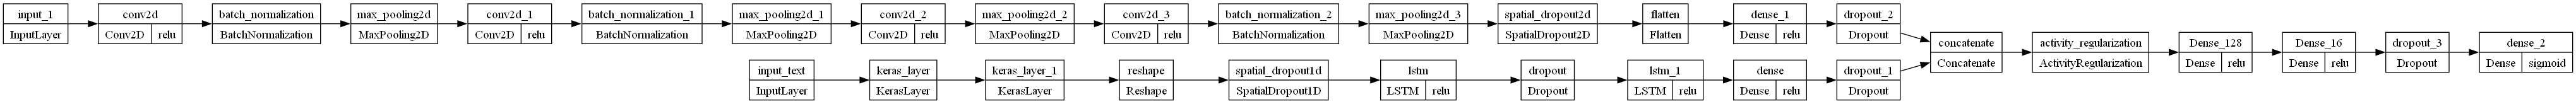

In [28]:
plot_model(model_multimodal, to_file='model_plot.png', show_layer_names=True, show_layer_activations=True, rankdir='LR')

In [29]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]

In [162]:
# # load weights
# model_multimodal.load_weights("good_weights.hdf5")

model_multimodal.compile(optimizer='adam', loss='binary_crossentropy', metrics=Metrics)

In [70]:
es = EarlyStopping(monitor='val_accuracy', 
                                mode='max', # don't minimize the accuracy!
                                patience=10)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=5, min_lr=0.001, verbose=1)
filepath="model.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [163]:
i_make_a_history = model_multimodal.fit(x=[train_df['Title'], X_train_img], y=y_train, 
                                        validation_data=([val_df['Title'], X_val_img], y_val), 
                                        epochs=50, batch_size = 20,
                                        callbacks = [annealer, es, checkpoint])

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5363 - precision: 0.4821 - recall: 0.4476
Epoch 1: val_accuracy did not improve from 0.78846
21/21 [==============================] - 17s 484ms/step - loss: 0.6918 - accuracy: 0.5363 - precision: 0.4821 - recall: 0.4476 - val_loss: 0.9764 - val_accuracy: 0.5769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5625 - precision: 0.5349 - recall: 0.2447
Epoch 2: val_accuracy did not improve from 0.78846
21/21 [==============================] - 8s 385ms/step - loss: 0.6846 - accuracy: 0.5625 - precision: 0.5349 - recall: 0.2447 - val_loss: 0.8502 - val_accuracy: 0.5769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.5841 - precision: 0.5904 - recall: 0.2606
Epoch 3: val_accuracy did not im

In [73]:
# Save the weights
model_multimodal.save_weights('good_weights.hdf5')

In [36]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

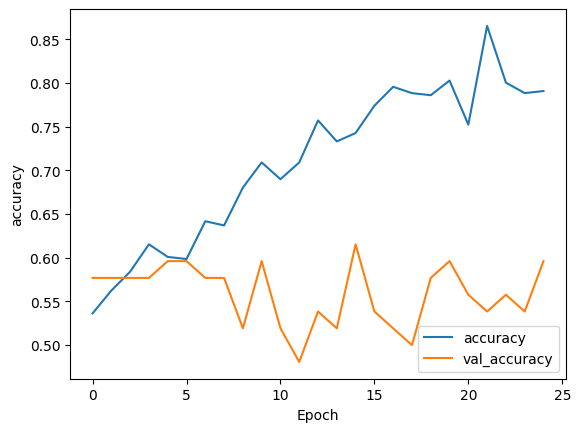

In [164]:
# check for overfit
show_performance_curve(i_make_a_history, 'accurac y', 'accuracy')

In [89]:
# model.evaluate(X_test2, y_test2)
model_multimodal.evaluate([X_val_txt, X_val_img], y_val)

2/2 [==============================] - 3s 339ms/step - loss: 0.5852 - accuracy: 0.6923 - precision: 0.6875 - recall: 0.5000


[0.5851935148239136, 0.692307710647583, 0.6875, 0.5]

In [169]:
saved_model = load_model('Models/78_on_val_84_on_train_LUV.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
# saved_model.summary()
score_on_train = saved_model.evaluate([X_train_txt, X_train_img], y_train)
score_on_val = saved_model.evaluate([X_val_txt, X_val_img], y_val)
score_on_test = saved_model.evaluate([X_test_txt, X_test_img], y_test)

# score_dict = {'val' : score_on_val, 'test' : score_on_test}
# df_score = pd.DataFrame(score_dict)
# df_score

ResourceExhaustedError: Graph execution error:

Detected at node 'model_12/batch_normalization_36/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\farras\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\farras\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\farras\anaconda3\envs\py310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\farras\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\farras\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\farras\AppData\Local\Temp\ipykernel_23936\769159923.py", line 3, in <module>
      score_on_train = saved_model.evaluate([X_train_txt, X_train_img], y_train)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\farras\anaconda3\envs\py310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_12/batch_normalization_36/FusedBatchNormV3'
OOM when allocating tensor with shape[32,16,128,233] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_12/batch_normalization_36/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_945421]

# Try Out the Models
Dalam prosesnya, tiap judul dan thumbnail akan melewati sebuah proses. 

Untuk title, berikut adalah prosesnya:
- apply fungsi text_preprocessing
- lemmatize 
- buang judul selain inggris

untuk thumbnail, berikut adalah prosesnya: 
- apply fungsi load_image from df but LUV

In [2]:
great_model = load_model('Models/78_on_val_84_on_train_LUV.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
predict = great_model.predict([X_test_txt, X_test_img]).flatten()
predict

NameError: name 'X_test_txt' is not defined

In [167]:
great_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 130, 235, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 233, 16  448         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 233, 16  64         ['conv2d_48[0][0]']              
 ormalization)                  )                                                          

In [168]:
predict_binary = np.where(predict > 0.5, 1, 0)
predict_binary

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0])

In [119]:
test_title = 'Build a web-app to serve a deep learning model for skin cancer detection'
test_thumbnail = 'https://i.ytimg.com/vi/BUh76-xD5qU/hq720.jpg?sqp=-oaymwEcCNAFEJQDSFXyq4qpAw4IARUAAIhCGAFwAcABBg==&rs=AOn4CLAi1f9XEsufbBjLn6EGmmezT9hptQ'

def title_adjusment_for_model(text):
    list_of_title = []
    
    if isEnglish(text):
        step1 = text_processing(text)
        step2 = lemmatize_words(step1)
        list_of_title.append(step2)
        return np.array(list_of_title)
    
    return ''

def thumbnail_adjusment_for_model(image_link):
    list_of_thumbnail = []
    
    img = skimage.io.imread(image_link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    img = cv2.resize(img, (235, 130))
    list_of_thumbnail.append(img)
    
    return np.array(list_of_thumbnail)


In [69]:
# cv2.imread("C:\\Users\\farras\\Downloads\\hq720_2.png")
cv2.imshow('ori', thumbnail_adjusment_for_model(test_thumbnail))
cv2.waitKey(0) 
cv2.destroyAllWindows() 

In [116]:
X_test_img[0:1].shape

(1, 130, 235, 3)

In [120]:
print(title_adjusment_for_model(test_title).shape)
print(thumbnail_adjusment_for_model(test_thumbnail).shape)

(1,)
(1, 130, 235, 3)


In [122]:
great_model = load_model('Models/80_on_val_78_on_train_LUV.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
predict_new = great_model.predict([title_adjusment_for_model(test_title), 
                                    thumbnail_adjusment_for_model(test_thumbnail)])
predict_new

1/1 [==============================] - 1s 1s/step


array([[0.17607489]], dtype=float32)